# 1

#### En el ejemplo de teoría hemos visto la forma de entrenar utilizando un trozo de datos como en la imagen "way1.png". 

(Básicamente, tener en cuenta más datos de entrenamiento [[20% de test]])

Investiga la forma de realizar el ejercicio a partir del gif "way3_sliding_window.gif":

- ¿Da mejores resultados entrenar el modelo así?

Algo muy típico en el trabajo de data scientist

![](../rnn/sliding_windows_google.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

In [2]:
# transforma la 'len' de 'data' en un array de 'len'' elementos de 'step' números (de ahí el shape del siguiente bloque)
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

# Permite trazar la época que se ha ejecutado en el entrenamiento en curso  
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 100 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

# compone una red neuronal rnn simple y la compila
def build_simple_rnn(num_units=128, embedding=4, num_dense=32,lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    # Long short term memory
    model.add(LSTM(units=num_units, input_shape=(1,embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

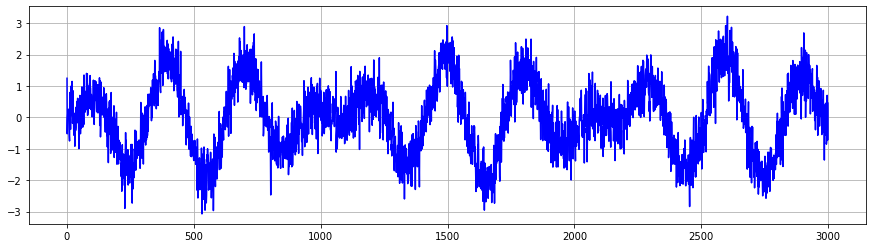

In [3]:
# Puntos generados para la serie temporal
N = 3000    # Total time points
t=np.arange(0,N)
x=(2*np.sin(0.02*t)*np.sin(0.003*t))+0.5*np.random.normal(size=N)
df = pd.DataFrame(x, columns=['Data'])
plt.figure(figsize=(15,4))
plt.plot(df,c='blue')
plt.grid(True)
plt.show()

C:\Users\barke\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


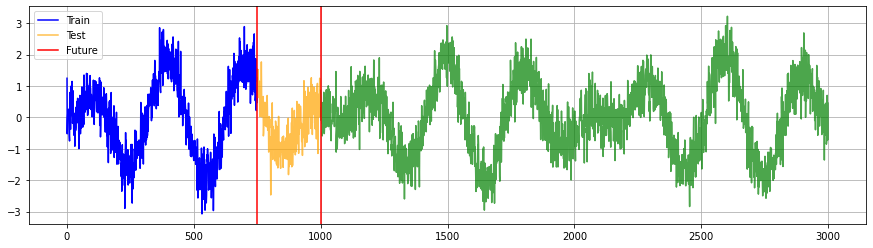

Epoch number 100 done
Epoch number 200 done
Epoch number 300 done
Epoch number 400 done
Epoch number 500 done


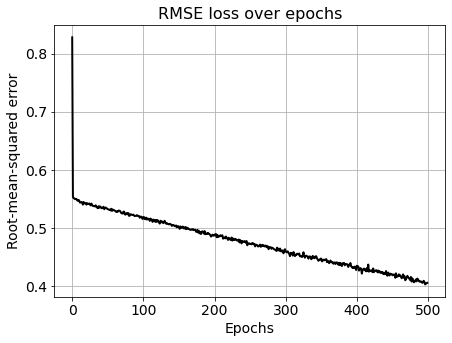

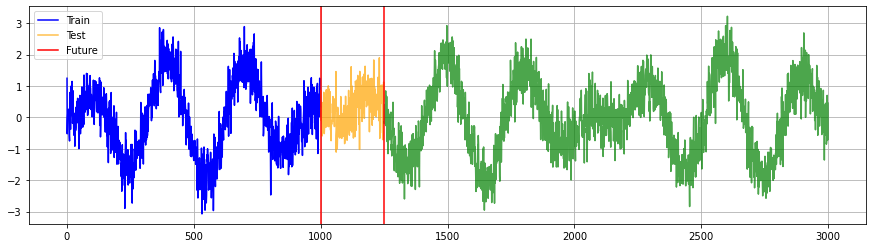

Epoch number 100 done
Epoch number 200 done
Epoch number 300 done
Epoch number 400 done
Epoch number 500 done


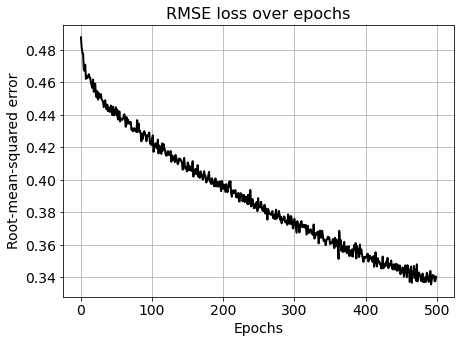

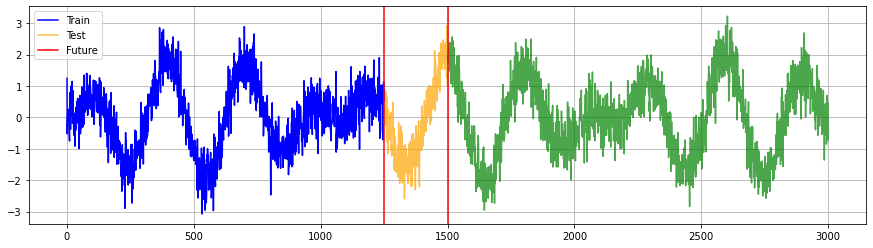

Epoch number 100 done
Epoch number 200 done
Epoch number 300 done
Epoch number 400 done
Epoch number 500 done


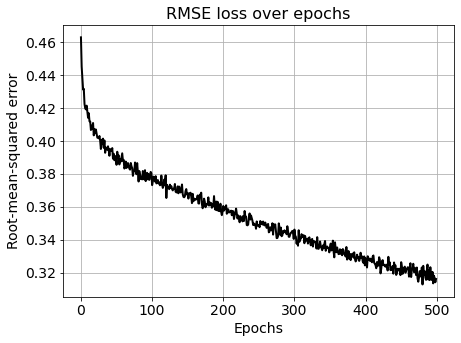

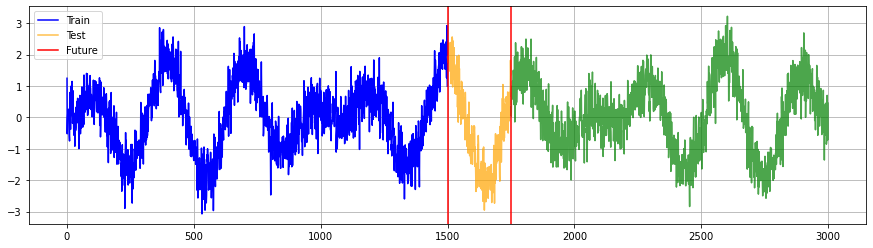

Epoch number 100 done
Epoch number 200 done
Epoch number 300 done
Epoch number 400 done
Epoch number 500 done


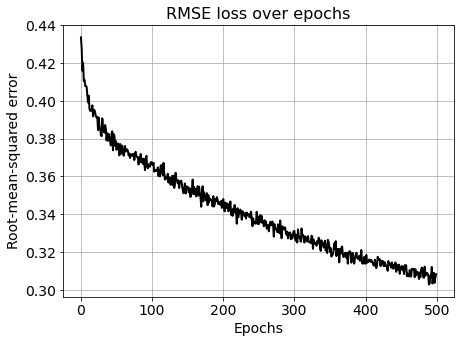

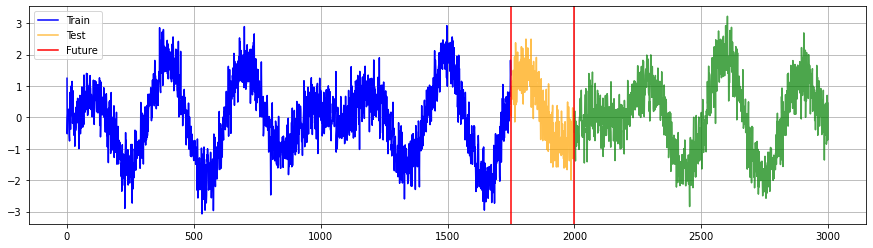

Epoch number 100 done
Epoch number 200 done
Epoch number 300 done
Epoch number 400 done
Epoch number 500 done


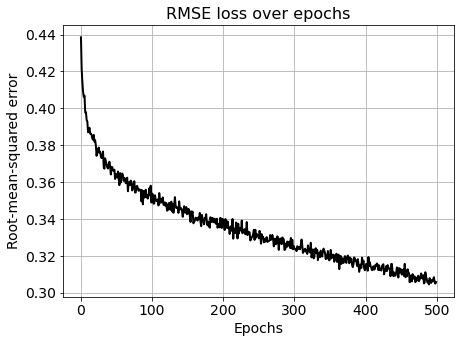

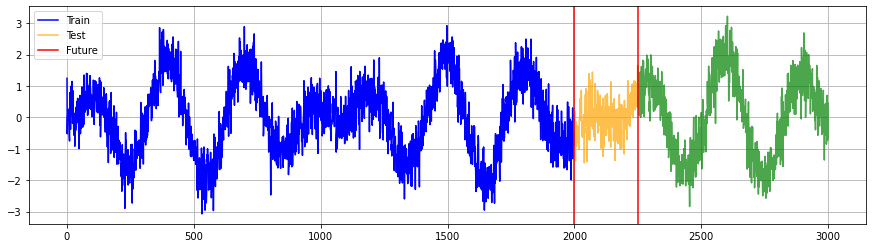

Epoch number 100 done
Epoch number 200 done
Epoch number 300 done
Epoch number 400 done
Epoch number 500 done


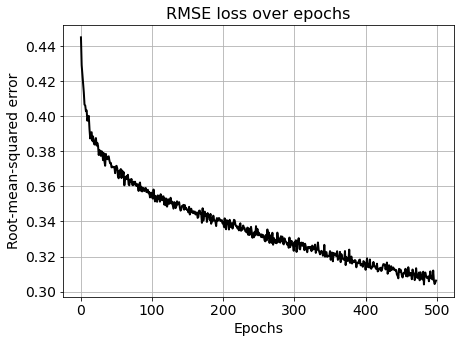

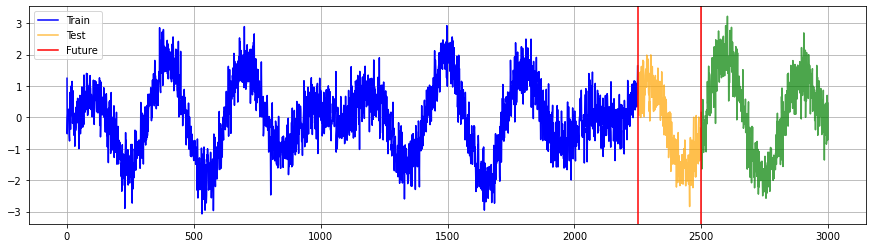

Epoch number 100 done
Epoch number 200 done
Epoch number 300 done
Epoch number 400 done
Epoch number 500 done


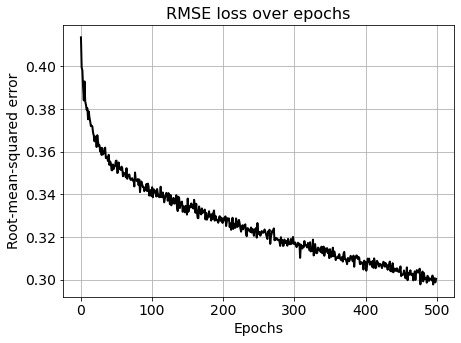

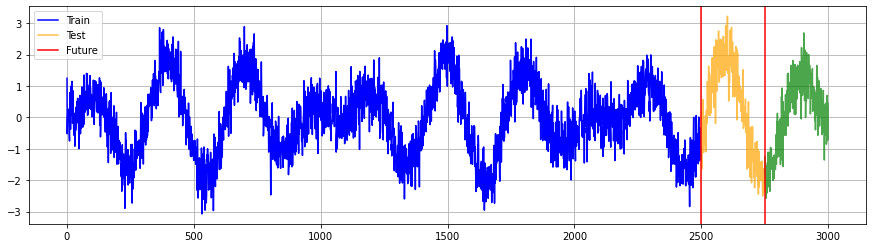

Epoch number 100 done
Epoch number 200 done
Epoch number 300 done
Epoch number 400 done
Epoch number 500 done


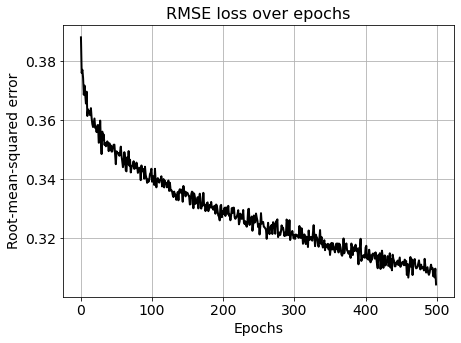

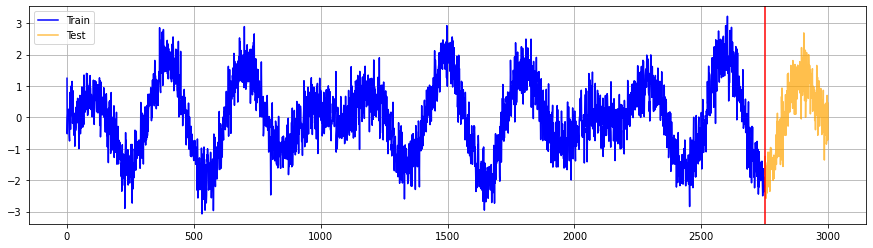

Epoch number 100 done
Epoch number 200 done
Epoch number 300 done
Epoch number 400 done
Epoch number 500 done


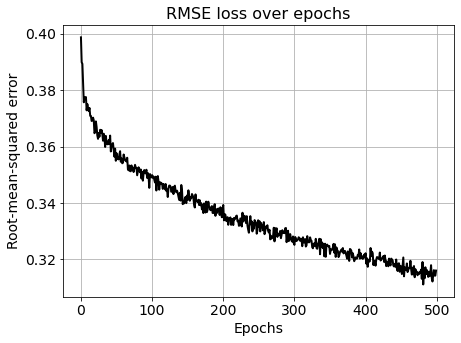

In [4]:
# Time point to partition train/test splits
Tp = 750   # this is the starting time point
Tw_test = 250 # this is the time window used for test values and to grow the train set
model = build_simple_rnn()
batch_size=16
num_epochs = 500
values = df.values
count = 1

while Tp+Tw_test < N-1 or count < 10:
    train, test, future = values[0:Tp ,:], values[Tp:Tp+Tw_test,:], values[Tp+Tw_test:N,:]

    # plot the set
    index = df.index.values
    plt.figure(figsize=(15,4))
    plt.plot(index[0:Tp],train,c='blue')
    plt.plot(index[Tp:Tp+Tw_test],test,c='orange',alpha=0.7)
    plt.axvline(df.index[Tp], c="r")
    if future.shape[0] != 0:
          plt.plot(index[Tp+Tw_test:N],future,c='green',alpha=0.7)
          plt.legend(['Train','Test', 'Future'])
          plt.axvline(df.index[Tp+Tw_test], c="r")
    else:
          plt.legend(['Train','Test'])

    plt.grid(True)
    plt.show()

    # con esta instrucción se añaden los elementos del 'eco' para poder entrenar los elementos de la cola
    # en este caso, al tener step = 4, se añaden 4 elementos al final del conjunto. 
    step = 4

    # add step elements into train and test
    test = np.append(test,np.repeat(test[-1,],step))
    train = np.append(train,np.repeat(train[-1,],step))

    # llamada a la función para convertir en matriz los distintos elementos
    trainX,trainY = convertToMatrix(train,step)
    testX,testY = convertToMatrix(test,step)

    # Para entrenar el modelo, necesito que los datos tengan la siguiente dimensión (750, 1, 4):
    # 750: el número total de trozos
    # 1: una fila de datos
    # 4: cada trozo tiene cuatro valores

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

    plt.figure(figsize=(7,5))
    plt.title("RMSE loss over epochs",fontsize=16)
    plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
    plt.grid(True)
    plt.xlabel("Epochs",fontsize=14)
    plt.ylabel("Root-mean-squared error",fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    count += 1
    Tp += Tw_test

In [6]:
Tp+Tw_test

3000

In [11]:
future.shape

(0, 1)